In [62]:
# Python script to initialise trajectories on a neutral density surface, for use with Ariane
# GM 16/9/16: Presently, this script is written for temperature, it will soon be adapted to use density
# GM 23/9/16: Presently, this script places one particle per grid cell, suitable for many applications. It will need to be adapted if I wish to initialise particales at higher resolution.

In [160]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os

In [65]:
# TRAJECTORY INITIALISATION OPTIONS
# Target density surface
sigT = 10

In [130]:
# ARIANE EXPERIMENT DIRECTORY
arianedir = '/Volumes/ocean2/graemem/ariane/experiments/orca025_global_5d/'
experiment = 'quant_back_seedGLOBALn1_tX_sign10_MLrefz8delsig0.01'

In [64]:
# DATASET LOCATION
# Specify the locations and filenames of the density and grid data
rootdir = '/Volumes/ocean1/DRAKKAR/ORCA025.L75-GJM189-S/'
datafileR = '2015/ORCA025.L75-GJM189_y2015m01d01_gridT.nc' # Density data
datafileT = '2015/ORCA025.L75-GJM189_y2015m01d01_gridT.nc' # Temperature and salinity data
hgridfile = 'GRID/ORCA025.L75-GRD88_mesh_hgr.nc'
zgridfile = 'GRID/ORCA025.L75-GRD88_mesh_zgr.nc'

In [66]:
# LOAD GRID DATA
hgrid = Dataset(rootdir+hgridfile,'r')
zgrid = Dataset(rootdir+zgridfile,'r')
deptht = zgrid.variables['gdept_0']
e1t = hgrid.variables['e1t']
e2t = hgrid.variables['e2t']

In [67]:
# LOAD DENSITY
dataR=Dataset(rootdir+datafileR,'r')
vosigntr=dataR.variables['votemper']
# Extract dimensions
(nz,ny,nx)=vosigntr.shape[1:4]
print nz, ny, nx

75 1021 1442


(0, 1021)

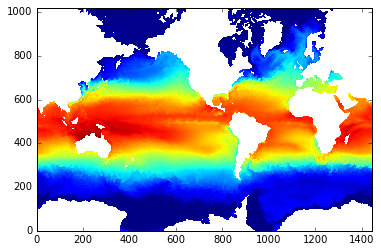

In [68]:
# PLOT SURFACE DENSITY
plt.pcolormesh(vosigntr[0,0,:,:])
plt.xlim(0,nx)
plt.ylim(0,ny)

In [69]:
# LOAD TEMPERATURE AND SALINITY
dataT = Dataset(rootdir+datafile,'r')
votemper=dataT.variables['votemper']
vosaline=dataT.variables['vosaline']

In [118]:
# FIND THE VERTICAL INDEX OF A TARGET DENSITY SURFACE AT EACH POINT IN SPACE
# In addition, vertically interpolate tracer values (temperature, salinity) onto this surface (required input for Ariane)
k = np.empty((nx,ny,))
k.fill(np.nan)
t = np.empty((nx,ny,))
t.fill(np.nan)
s = np.empty((nx,ny,))
s.fill(np.nan)
for i in range(500,510):#nx):
    print i
    for j in range(500,510):#ny):
        # Find the first occasion when the column density exceeds the target density
        # GM 23/9/16: This is presently reversed while dealing with temperature, i.e. first occasion when temp < target temp
        lessarray = np.where(vosigntr[0,:,j,i]-sigT < 0)[0]
        morearray = np.where(vosigntr[0,:,j,i]-sigT > 0)[0]
        if morearray.size==0 or lessarray.size==0:
            k[i,j]=np.nan
        else:
            more = morearray[-1]
            less = lessarray[0]
            # 'less' index should be smaller than 'more' index. If this is not the case, skip past this grid cell.
            if less>more: # GM 23/9/19: This is what needs to be switched when dealing with density
                # Determine how far target surface is from the 'less' surface
                diffless = abs(vosigntr[0,less,j,i]-sigT)
                diffmore = abs(vosigntr[0,more,j,i]-sigT)
                ratio = diffless/np.sum([diffless, diffmore]) # Distance from 'less' surface as a ratio of total density difference
                # Specify vertical index for initial particle position
                k[i,j] = less+ratio+0.5 # Addition of 0.5 adjusts for Ariane indexing conventions (indices are relative to velocity points)
                # Interpolate tracer values
                t[i,j] = votemper[0,less,j,i]+ratio*np.absolute(votemper[0,more,j,i]-votemper[0,less,j,i])
                s[i,j] = vosaline[0,less,j,i]+ratio*np.absolute(vosaline[0,more,j,i]-vosaline[0,less,j,i])
            else:
                k[i,j]=np.nan

500
501
502
503
504
505
506
507
508
509


In [119]:
print less, more, ratio#votemper[0,less,j,i], votemper[0,more,j,i]

36 35 0.517851810241


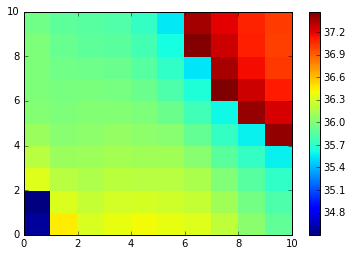

In [127]:
# PLOT VERTICAL INDEX OF DENSITY SURFACE ISOPYCNAL
plt.pcolormesh(k[500:510,500:510])
plt.colorbar()

In [121]:
# PUT INDICES INTO ARIANE FORMAT
# Specify arrays
init_x = np.array([])
init_y = np.array([])
init_z = np.array([])
init_temp = np.array([])
init_salt = np.array([])
init_dens = np.array([])
init_area= np.array([])
init_transp = np.array([])
ntot=0 # Keep track of number of initialised particles

for i in range(500,510):
    for j in range(500,510):
        if np.isfinite(k[i,j]):
            # For positioning: -0.5 due to Ariane convention (index relative to velocity points), +1 due to python indexing conventions
            init_x = np.append(init_x,i-0.5+1)
            init_y = np.append(init_y,j-0.5+1)
            init_z = np.append(init_z,k[i,j])
            init_temp = np.append(init_temp,t[i,j])
            init_salt = np.append(init_salt,s[i,j])
            init_dens = np.append(init_dens,sigT)
            init_area = np.append(init_area,e1t[0,j,i]*e2t[0,j,i])
            init_transp = np.append(init_transp,np.nan) # GM 23/9/16: Presently, do not specify a transport. Fudge to satisfy Ariane.
            
            # STEP FORWARD NTOT
            ntot = ntot+1
            
            

In [169]:
os.remove(arianedir+experiment+'/ariane_initial.nc')

In [170]:
# SAVE AS A NETCDF FILE
ariane = Dataset(arianedir+experiment+'/ariane_initial.nc','w',format='NETCDF4_CLASSIC')
# Create dimensions
ariane.createDimension('ntot',ntot)
# Create variables
x = ariane.createVariable('init_x','f8',('ntot',))
y = ariane.createVariable('init_y','f8',('ntot',))
z = ariane.createVariable('init_z','f8',('ntot',))
temp = ariane.createVariable('init_temp','f8',('ntot',))
salt = ariane.createVariable('init_salt','f8',('ntot',))
dens = ariane.createVariable('init_dens','f8',('ntot',))
area = ariane.createVariable('init_area','f8',('ntot',))
transp = ariane.createVariable('init_transp','f8',('ntot',))
# Write to variables
x = init_x
y = init_y
z = init_z
temp = init_temp
salt = init_salt
dens = init_dens
area = init_area
transp = init_transp
# Close netcdf
ariane.close()

IOError: Permission denied